In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage
from sklearn.utils import shuffle

%matplotlib inline

Read in the processed metadata.

In [2]:
photo_data = pd.read_csv('processed_photo_metadata.csv')
photo_data.head()

,photo_path,name,gender,age
0,01/nm0000001_rm946909184_1899-5-10_1968.jpg,Fred Astaire,1,69
1,01/nm0000001_rm980463616_1899-5-10_1968.jpg,Fred Astaire,1,69
2,02/nm0000002_rm221957120_1924-9-16_1974.jpg,Lauren Bacall,0,49
3,02/nm0000002_rm238734336_1924-9-16_1974.jpg,Lauren Bacall,0,49
4,02/nm0000002_rm370988544_1924-9-16_1991.jpg,Lauren Bacall,0,66


We are going to partition the photo metadata into 3 sets: the test set, the validation set and the train set. We want to ensure that:
- the model is trained, validated and tested on disjoint sets of face photos, 
- the photos of the same person do not appear too frequently in the validation and test sets so as not to skew the results.

Given the above reasoning, we form:
- the test set by selecting the photos of people who appear 1 or 3 times in the data set, 
- the validation set by selecting the photos of people who appear 2 times in the data set,
- the train set by selecting the remaining photos, i.e., the photos of people who appear at least 4 times in the data set, and shuffling them randomly since, apparently, they are ordered by name.

Such assignment roughly maximizes the number of different faces in the validation and test sets. On the downside, as will be shown presently, this arbitrary choice somewhat disrupts the distributon of certain key characteristics.

In [3]:
name_count = photo_data['name'].value_counts()

test_index = photo_data['name'].apply(lambda name: name_count[name]).isin([1, 3])
valid_index = photo_data['name'].apply(lambda name: name_count[name]) == 2
train_index = photo_data['name'].apply(lambda name: name_count[name]) > 3

In [4]:
train_set = photo_data.loc[train_index, ['photo_path', 'name', 'gender', 'age']].copy()
train_set = shuffle(train_set, random_state=7532).drop(columns=['name']).reset_index(drop=True)
print(f'Number of datapoints in the train set: {train_set.shape[0]}')

valid_set = photo_data.loc[valid_index, ['photo_path', 'gender', 'age']].copy()
valid_set = valid_set.reset_index(drop=True)
print(f'Number of datapoints in the validation set: {valid_set.shape[0]}')

test_set = photo_data.loc[test_index, ['photo_path', 'gender', 'age']].copy()
test_set = test_set.reset_index(drop=True)
print(f'Number of datapoints in the test set: {test_set.shape[0]}')

Number of datapoints in the train set: 165400
Number of datapoints in the validation set: 4176
Number of datapoints in the test set: 7621


**Gender distribution** <br>
The train set is more balanced that the other two sets which happen to have almost identical gender distributions.

In [5]:
print('Train set:')
print(train_set['gender'].value_counts(normalize=True).apply(lambda x: str(round(100*x, 2)) + '%'))
print()

print('Validation set:')
print(valid_set['gender'].value_counts(normalize=True).apply(lambda x: str(round(100*x, 2)) + '%'))
print()

print('Test set:')
print(test_set['gender'].value_counts(normalize=True).apply(lambda x: str(round(100*x, 2)) + '%'))

Train set:
1    54.34%
0    45.66%
Name: gender, dtype: object

Validation set:
1    61.83%
0    38.17%
Name: gender, dtype: object

Test set:
1    61.07%
0    38.93%
Name: gender, dtype: object


**Age distribution** <br>
The overall shape is roughly the same and all sets contain the whole chosen age spectrum. However, the validation and test sets share more similarities with one another than with the train set which has 'thiner tails'.

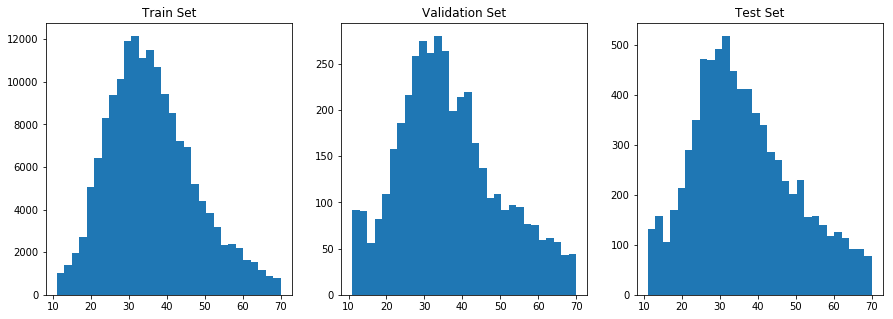

In [6]:
bins = 30
_, axs = plt.subplots(1, 3, figsize=(15, 5), sharex=True)
axs[0].hist(train_set['age'], bins=bins);
axs[0].set_title('Train Set');
axs[1].hist(valid_set['age'], bins=bins);
axs[1].set_title('Validation Set');
axs[2].hist(test_set['age'], bins=bins);
axs[2].set_title('Test Set');

## Train-Validation-Test Data Preparation

In [7]:
PHOTO_DIR = 'imdb_crop/'

It turns out that there are two more issues to contend with:
- the majority of the photos are 3-dimensional (2 size dimensions plus 1 color dimension) but some of them are 2-dimensional (2 size dimensions only)
- photo size is not the same for all photographs

We deal with them by first converting 2D photos to 3D photos and then resizing the photos to size 320x320. Having performed these operations, we save the resulting photos for further use. 

In [9]:
def convert_to_3D(img):
    """Converts a 2D image to a 3D image."""
    
    img_3D = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.float32)       
    img_3D[:,:,0], img_3D[:,:,1], img_3D[:,:,2] = img, img, img
    
    return img_3D 


def homogenize_images(img_path_series, img_dir=PHOTO_DIR, output_dir='_all_photos/', new_width=320, new_height=320, 
                      only_save_to_disk=True):
    """
    1) Resizes images to new_width and new_height 
    2) Converts 2D images to 3D images 
    3) Creates and returns an array of homogenized 3D images/only saves the trasformed images to disk 
    4) Retuns 2D image count
    """
    
    count_2D = 0
    
    if only_save_to_disk:
        indx = 0
    else:
        homogenized_image_array = []
    
    for img_name in img_path_series:        
        img = plt.imread(img_dir + img_name)
        
        if (img.shape[0] == new_width) and (img.shape[1] == new_height):
            img = (img / 255.0).astype(np.float32)
        else:
            # The resize function returns a float64 representation of an image
            img = skimage.transform.resize(img, (new_width, new_height), 
                                           order=3, mode='reflect', 
                                           anti_aliasing=True).astype(np.float32)
        
        # Turn 2D images into 3D images
        if img.ndim == 2:            
            img = convert_to_3D(img)           
            count_2D += 1
        
        
        if only_save_to_disk:
            new_img_name = img_name[3:-4] + '_HMGD' + img_name[-4:]    
            plt.imsave(img_dir + output_dir + new_img_name, img)
            img_path_series[indx] = new_img_name
            indx += 1
        else:
            homogenized_image_array.append(img)
    
    if only_save_to_disk:
        return count_2D
    else:
        homogenized_image_array = np.array(homogenized_image_array)
        return homogenized_image_array , count_2D

In [18]:
%%time
count_2D = homogenize_images(valid_set.loc[:, 'photo_path'])
print('Validation set:')
print(f'Number of 2D photos converted to 3D: {count_2D}\n')

c:\users\rafal_pikula_01\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Validation set:
Number of 2D photos converted to 3D: 418

Wall time: 11min


In [24]:
%%time
count_2D = homogenize_images(test_set.loc[:, 'photo_path'])
print('Test set')
print(f'Number of 2D photos converted to 3D: {count_2D}\n')

c:\users\rafal_pikula_01\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


test set
Number of 2D photos converted to 3D: 738

Wall time: 19min 41s


In [27]:
%%time
count_2D = homogenize_images(train_set.loc[:, 'photo_path'])
print('Train set')
print(f'Number of 2D photos converted to 3D: {count_2D}\n')

c:\users\rafal_pikula_01\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Train set
Number of 2D photos converted to 3D: 6132

Wall time: 7h 11min 4s


Finally, we can save the appropriately adjusted train, validation and test sets.

In [28]:
train_set.to_csv('train_set_metadata_HMGD.csv', index=False)
valid_set.to_csv('valid_set_metadata_HMGD.csv', index=False)
test_set.to_csv('test_set_metadata_HMGD.csv', index=False)

Prepare and save the test set as a numpy array.

In [10]:
%%time
test_image_array, count_2D = homogenize_images(test_set.loc[:, 'photo_path'], only_save_to_disk=False)
print('Test set')
print(f'Number of 2D photos converted to 3D: {count_2D}\n')

Test set
Number of 2D photos converted to 3D: 738

Wall time: 7min 32s


In [12]:
np.save('test_set_hmgd_arr.npy' ,test_image_array)